# Naive Learning

We first explore the basic algorithms: Linear Regression and Random Forest Regressors.

In [1]:
%load_ext autoreload

In [2]:
%run ../modules.ipynb

/Users/ilaif/.virtualenvs/ds/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


#### Feature enrichment

In [4]:
init_data_paths("ilai")
print('loading data...')
train, test = load_data(DATA_PATH)
train, test = basic_enrichment(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = load_image_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = load_text_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = add_aggregated_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = numeric_features_cleaning(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = complete_image_top_1(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = complete_price(train, test, helper_data_path=HELPER_DATA_PATH)
phase_1_train = train.copy()
phase_1_test = test.copy()

loading data...
Adding basic features...
Done adding basic features.
Adding image features...


/Users/ilaif/Google Drive/uni/ds-workshop/Avito/utils/feature_enrichment.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ilaif/Google Drive/uni/ds-workshop/Avito/utils/feature_enrichment.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Done loading image features.
Loading text features...
loading tfidf features...
Done loading text features.
Loading aggregated features...
Done loading aggregated features.
Loading aggregated features...
Done loading aggregated features.
Cleaning and completing numeric features...


/Users/ilaif/Google Drive/uni/ds-workshop/Avito/utils/feature_enrichment.py:170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Done cleaning numeric features.
Completing image_top_1 features...
Done loading image_top_1 completions.
Completing price...
Done loading log_price_regression.


/Users/ilaif/Google Drive/uni/ds-workshop/Avito/utils/feature_enrichment.py:171: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
list(train.columns)

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'deal_probability',
 'has_description',
 'has_price',
 'has_params',
 'has_image',
 'month',
 'day',
 'weekday',
 'user_ads_count',
 'title_description_params',
 'img_size',
 'img_sharpness',
 'img_luminance',
 'img_colorfulness',
 'img_confidence',
 'img_keypoints',
 'log_img_sharpness',
 'log_img_keypoints',
 'title_word_count',
 'description_non_regular_chars_ratio',
 'description_word_count',
 'merged_params_word_count',
 'description_sentence_count',
 'description_words/sentence_ratio',
 'title_capital_letters_ratio',
 'description_capital_letters_ratio',
 'title_non_regular_chars_ratio',
 'title_num_of_newrow_char',
 'description_num_of_newrow_char',
 'title_num_adj',
 'title_num_nouns',
 'title_adj_to_len_ratio',
 'title_noun_to_len_ratio',
 '

In [6]:
categorical_cols = ['user_type', \
                'region', 'city', \
                'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', \
                'image_top_1_class', 'image_top_1_rounded_regression', \
                'month', 'day', 'weekday', \
                'has_price', 'has_description', 'has_params', 'has_image',
                   ]
numerical_cols = ['image_top_1_regression', \
                     'log_price_regression', \
                     'avg_days_up_user', 'avg_times_up_user', 'n_user_items', 'user_ads_count', \
                     'log_item_seq_number', \
                     'img_size', 'img_luminance', 'img_colorfulness', 'img_confidence', 'log_img_sharpness', 'log_img_keypoints', \
                     'title_word_count', 'description_word_count', 'merged_params_word_count', \
                     'description_non_regular_chars_ratio', 'title_capital_letters_ratio','description_capital_letters_ratio', \
                     'title_non_regular_chars_ratio', 'title_adj_to_len_ratio', 'title_noun_to_len_ratio',\
                     'title_sentiment',
                     'title_svd_1_ngram', 'title_svd_2_ngram', 'title_svd_3_ngram', 'title_svd_4_ngram', 'title_svd_5_ngram',
                     'description_svd_1_ngram', 'description_svd_2_ngram', 'description_svd_3_ngram', 'description_svd_4_ngram', 'description_svd_5_ngram',
                 ]

feature_list = categorical_cols + numerical_cols

def categorical_indices(df, categorical_cols):
    return [i for i, col in enumerate(df.columns) if col in categorical_cols]

#### Encoding Labels

In [7]:
import gc
gc.collect()
for col in categorical_cols:
    print ("Encoding "+ str(col) + "...")
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

Encoding user_type...
Encoding region...
Encoding city...
Encoding parent_category_name...
Encoding category_name...
Encoding param_1...
Encoding param_2...
Encoding param_3...
Encoding image_top_1_class...
Encoding image_top_1_rounded_regression...
Encoding month...
Encoding day...
Encoding weekday...
Encoding has_price...
Encoding has_description...
Encoding has_params...
Encoding has_image...


#### Splitting data

In [8]:
X_df = train[feature_list].fillna(0)
y_df = train['deal_probability'].values
X_test_df = test[feature_list].fillna(0)
y_test_df = train['deal_probability'].values
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

## Naive random prediction

In [12]:
results = {}

In [16]:
y_pred = np.random.randint(1, size=y_val_df.shape[0])
res = rmse(y_pred, y_val_df)
print(res)
results['naive'] = { 'rmse': res }

0.29462199504489484


## Linear Regression

In [18]:
l = LinearRegression()
l.fit(X_train_df, y_train_df)
y_pred = l.predict(X_val_df)
res = rmse(y_pred, y_val_df)
print(res)
results['linear_regression'] = { 'rmse': res }

/Users/ilaif/.virtualenvs/ds/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



0.24653512555395826


## Random Forest Regressor

In [19]:
r = RandomForestRegressor(n_estimators=25, max_depth=10, n_jobs=-1)
r.fit(X_train_df, y_train_df)
y_pred = r.predict(X_val_df)
res = rmse(y_pred, y_val_df)
print(res)
results['random_forest_regressor'] = { 'rmse': res }

0.23291872681039355


## Results

We can see that the random regressor does the best work, but as we will see later, lgbm, catboost and nn does a much better job

In [23]:
algs = []
rmse = []
for alg, metrics in results.items():
    algs.append(alg)
    rmse.append(metrics['rmse'])

<BarContainer object of 3 artists>

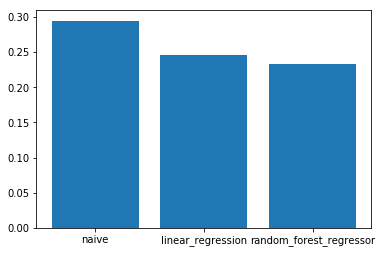

In [24]:
plt.bar(algs, rmse)